In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM_AGM)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv
from src.features.add_features import features_graph, features_pop

In [2]:
import xgboost as xgb
import pandas as pd
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, expon, randint, loguniform

In [3]:
df = pd.read_pickle(f'{root_project}/data/processed/sir_simulation_100k.pickle')

In [4]:
df = features_graph(df)
df = features_pop(df)

In [5]:
df_model = df[['Tr', 'infection_power', 'mortality_power', 'limit_deaths', 'n_closed', 'react_time',
               'total_death', 'betweenness', 'degree', 'closeness', 'country_pop']]


# df_model = df_model.sample(30000) # par entrenar con menos muestras

size_data = int(len(df) / 1000)

df_model

,Tr,infection_power,mortality_power,limit_deaths,n_closed,react_time,total_death,betweenness,degree,closeness,country_pop
0,21.014286,2.918571e+03,0.007146,72,6,23,519114130.0,0.001057,0.270270,0.460581,6848925.0
1,19.323523,9.342214e+03,0.003708,872,2,2,63875904.0,0.000956,0.036036,0.391534,115847.0
2,20.771054,8.045407e+04,0.002847,192,0,22,257680389.0,0.000059,0.054054,0.382759,29495962.0
3,2.461249,5.593643e+03,0.006883,511,9,28,69844201.0,0.000007,0.049550,0.368159,3213972.0
4,11.121400,9.890000e+03,0.013340,958,18,20,222144686.0,0.000035,0.040541,0.312236,110210.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,11.547730,2.119500e+03,0.006201,13,2,15,323427.0,0.001189,0.342342,0.485777,10625695.0
99996,17.028439,6.076714e+03,0.023638,76,15,29,5090723.0,0.000831,0.216216,0.449393,18276499.0
99997,2.162848,4.316507e+06,0.028820,434,12,21,1775100.0,0.017998,0.707207,0.572165,60431283.0
99998,13.087873,2.108246e+05,0.019523,788,3,14,231336.0,0.000054,0.117117,0.424474,2951776.0


In [6]:
X = df_model.drop('total_death', axis=1)
y = df_model['total_death']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'df_train_val' is not defined

In [16]:
param_dist = dict(
    max_depth=randint(low=1, high=11),
    learning_rate=loguniform(0.01, 0.1),
    subsample=uniform(loc=0.8, scale=1-0.8),
    colsample_bytree=uniform(loc=0.8, scale=1-0.8),
    gamma=[0, 1, 5]
)

# model = xgb.XGBRegressor(scale_pos_weight=1,
#                          learning_rate=0.01,
#                          colsample_bytree=0.4,
#                          subsample=0.8,
#                          n_estimators=100,
#                          reg_alpha=0.3,
#                          max_depth=4,
#                          gamma=10)

grid = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=param_dist, verbose=2,
                          n_iter=100, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.9min finished


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc8f87e3640>,
                                        'gamma': [0, 1, 5],
                  

In [17]:
results_searchcv(grid, X_test, y_test)

The best score is:
-193174131477975.94
The best parameters found are:
{'colsample_bytree': 0.9815387412697093, 'gamma': 0, 'learning_rate': 0.056673258708039034, 'max_depth': 6, 'subsample': 0.94163623911664}
The score in test is:
-65647816377279.234
The r2-square is
0.8174348629484902
The MAE is:
1383740.8170146453


In [10]:
X_err = X_test.copy()
X_err['predicted'] = grid.predict(X_test)
X_err['real'] = y_test
X_err['error'] = X_err['real'] - X_err['predicted']
X_err['abs_error'] = np.abs(X_err['error'])
X_err

,Tr,infection_power,mortality_power,limit_deaths,n_closed,react_time,betweenness,degree,closeness,country_pop,predicted,real,error,abs_error
75721,11.512972,23.857143,0.062874,990,11,9,0.008194,0.175676,0.463466,18729160.0,4.317070e+06,2399430.0,-1.917640e+06,1.917640e+06
80184,7.099316,346649.571429,0.011172,338,16,9,0.003207,0.306306,0.495536,4853506.0,9.341274e+05,107259.0,-8.268684e+05,8.268684e+05
19864,17.975615,867005.000000,0.002929,794,2,25,0.009627,0.387387,0.526066,33699947.0,1.811112e+06,1810182.0,-9.303750e+02,9.303750e+02
76699,3.788375,52681.928571,0.036562,173,1,15,0.000193,0.121622,0.411874,19751535.0,2.914486e+06,3447814.0,5.333278e+05,5.333278e+05
92991,9.060127,3944.571429,0.095520,587,15,15,0.000000,0.009009,0.383420,55312.0,2.708078e+05,8521.0,-2.622868e+05,2.622868e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32595,19.122211,7613.000000,0.017311,971,0,9,0.002871,0.054054,0.388792,106977.0,6.130771e+05,6099.0,-6.069781e+05,6.069781e+05
29313,11.765232,1708.071429,0.014971,633,13,27,0.006499,0.121622,0.433594,96286.0,1.569189e+05,7607.0,-1.493119e+05,1.493119e+05
37862,4.013381,35861.571429,0.007597,440,10,12,0.000579,0.072072,0.370618,8606316.0,5.127129e+05,243582.0,-2.691309e+05,2.691309e+05
53421,2.988766,9385.785714,0.010449,38,9,7,0.001501,0.189189,0.460581,95540395.0,4.403843e+06,2554020.0,-1.849823e+06,1.849823e+06


In [11]:
X.describe()

,Tr,infection_power,mortality_power,limit_deaths,n_closed,react_time,betweenness,degree,closeness,country_pop
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,12.001955,7.678586e+05,0.031564,500.815290,9.527970,15.022590,0.006649,0.194115,0.439997,3.727047e+07
std,5.769646,4.712629e+06,0.045923,288.703688,5.766858,8.377824,0.019031,0.189428,0.065787,1.414215e+08
min,2.000186,5.000000e+00,0.000534,1.000000,0.000000,1.000000,0.000000,0.009009,0.296395,1.164600e+04
25%,7.000645,3.156286e+03,0.007166,250.000000,5.000000,8.000000,0.000058,0.063063,0.392920,1.136191e+06
50%,12.028737,3.453154e+04,0.015806,502.000000,10.000000,15.000000,0.000554,0.126126,0.427746,7.024216e+06
75%,16.979347,3.449563e+05,0.035912,751.000000,15.000000,22.000000,0.003897,0.261261,0.478448,2.626237e+07
max,21.999318,9.948071e+07,0.735099,999.000000,19.000000,29.000000,0.184702,0.995495,0.634286,1.392730e+09


In [12]:
X_err.sort_values(by='abs_error', ascending=False).iloc[:100].describe()

,Tr,infection_power,mortality_power,limit_deaths,n_closed,react_time,betweenness,degree,closeness,country_pop,predicted,real,error,abs_error
count,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.0,1.000000e+02,1.000000e+02,1.000000e+02
mean,11.916428,1.690798e+07,0.047276,484.260000,9.110000,15.360000,0.032127,0.428468,0.523439,7.523744e+08,132197336.0,1.625061e+08,3.030873e+07,7.549395e+07
std,6.227468,3.490280e+07,0.044508,288.611326,5.504626,9.060426,0.049605,0.211136,0.060761,6.236752e+08,116491096.0,1.649738e+08,1.058882e+08,7.989560e+07
min,2.000849,1.028571e+01,0.004184,2.000000,0.000000,1.000000,0.000000,0.009009,0.356913,3.370100e+04,391230.5,1.004700e+04,-1.564551e+08,2.486848e+07
25%,5.802756,4.852500e+02,0.016505,222.500000,5.000000,7.000000,0.006249,0.278153,0.495296,1.399908e+08,44875192.0,5.296774e+07,-2.977715e+07,2.974368e+07
50%,11.590293,1.823421e+04,0.030215,509.000000,9.000000,16.000000,0.017188,0.441441,0.537530,3.271674e+08,79253664.0,1.149915e+08,2.973593e+07,4.337747e+07
75%,17.250516,6.977130e+06,0.059144,705.500000,13.000000,23.250000,0.030666,0.563063,0.560606,1.392730e+09,194507284.0,2.083972e+08,5.147676e+07,9.356816e+07
max,21.636056,9.948071e+07,0.213906,992.000000,19.000000,29.000000,0.184702,0.819820,0.620112,1.392730e+09,564347136.0,9.903641e+08,4.260169e+08,4.260169e+08


In [13]:
y_predicted = grid.predict(X_test)
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})

In [14]:
df_predicted

,Actual,Predicted
75721,2399430.0,4.317070e+06
80184,107259.0,9.341274e+05
19864,1810182.0,1.811112e+06
76699,3447814.0,2.914486e+06
92991,8521.0,2.708078e+05
...,...,...
32595,6099.0,6.130771e+05
29313,7607.0,1.569189e+05
37862,243582.0,5.127129e+05
53421,2554020.0,4.403843e+06


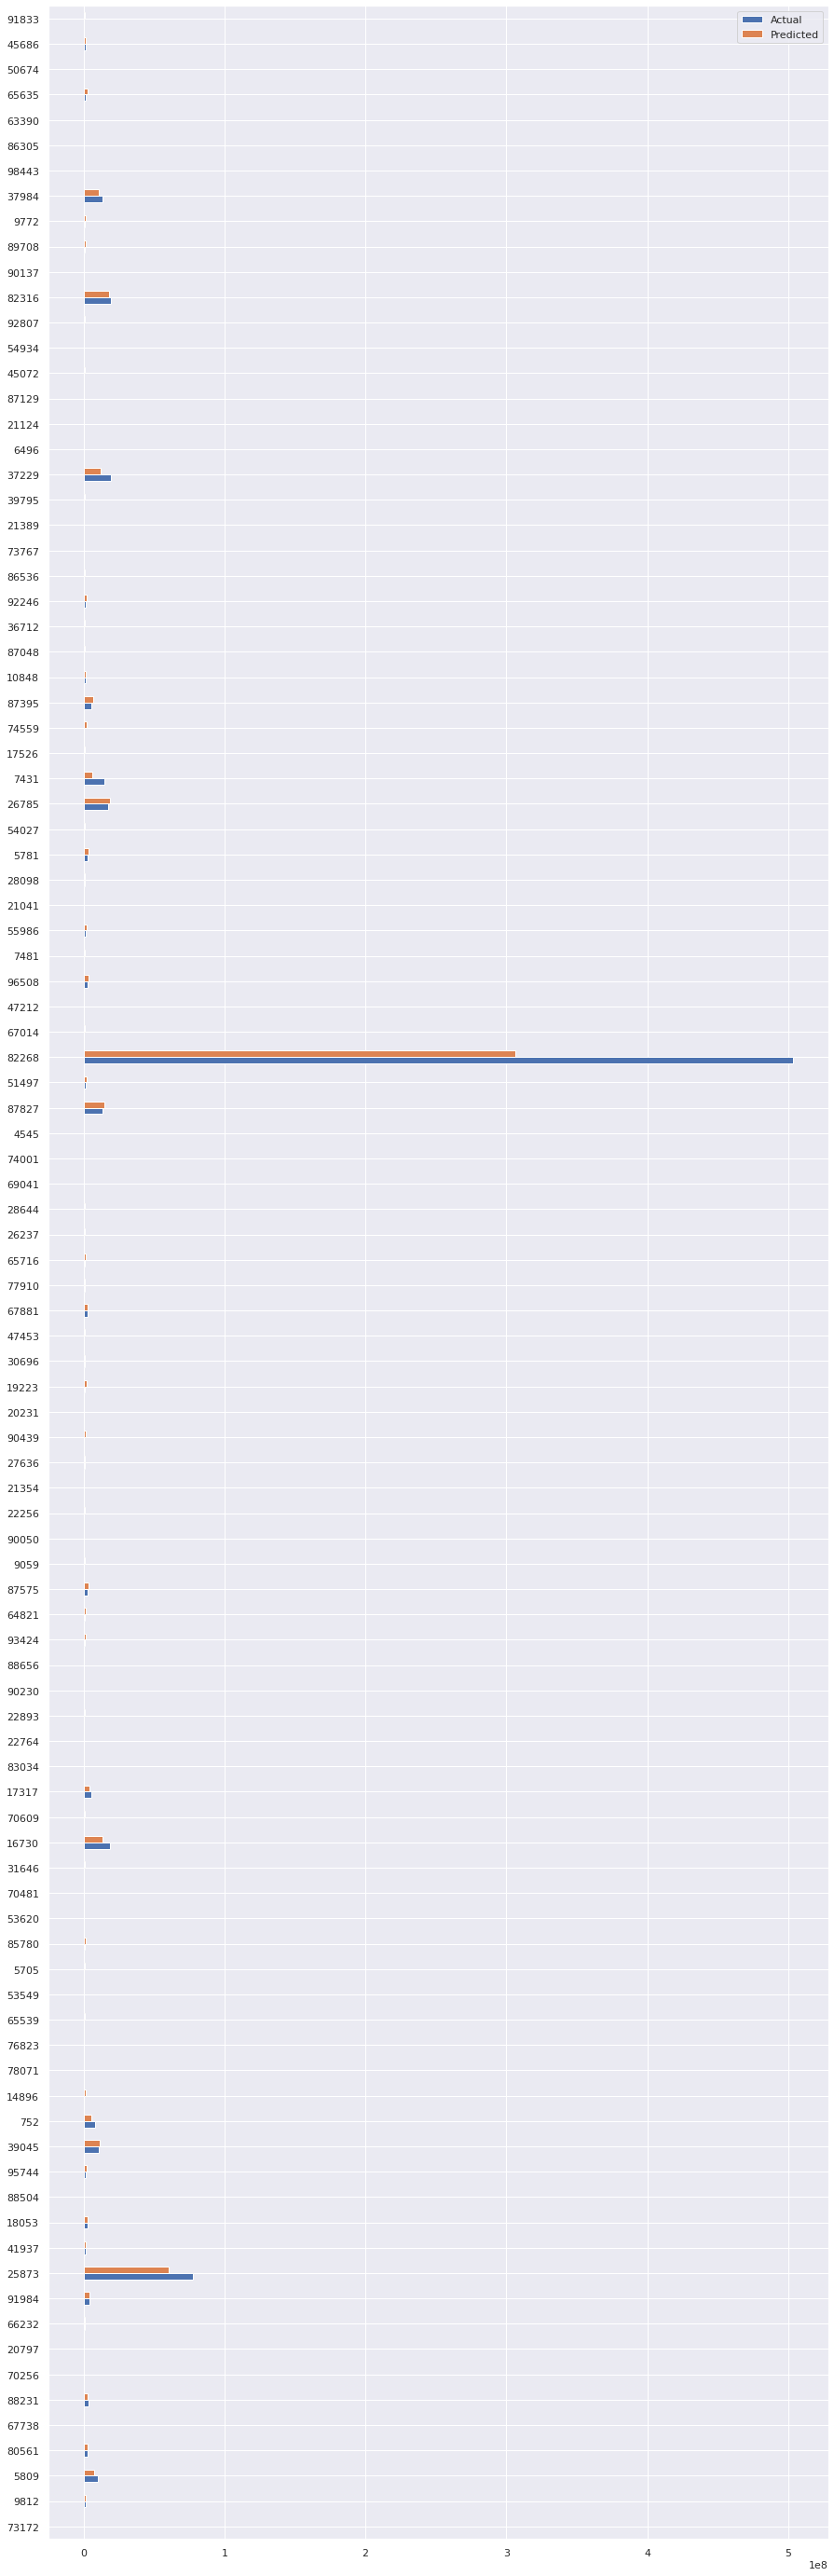

In [15]:
df_predicted.sample(100).plot(kind='barh',figsize=(15,50))
plt.show()